In [1]:
from qiskit import *
import numpy as np
from IPython.display import clear_output
%matplotlib inline
clear_output()

In this notebook I try to give a solution for task 2 using the strategy described in section IV of this paper https://arxiv.org/pdf/0905.2794.pdf

I give descriptions in the code below.

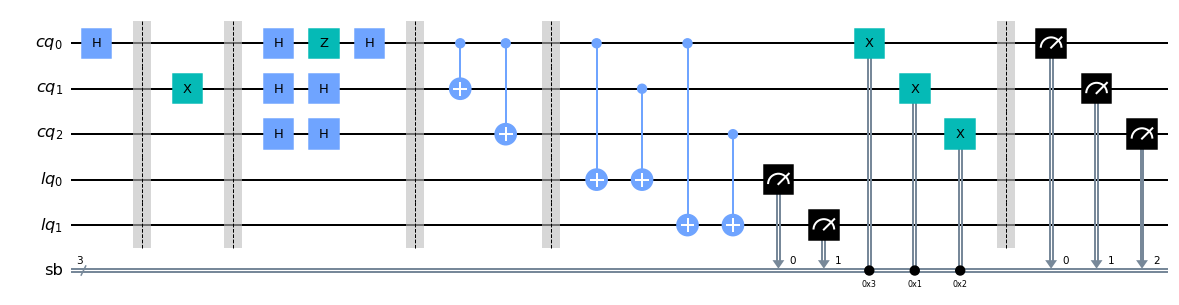

In [11]:
cq = QuantumRegister(3,'cq')   # Three physical bits to encode 1 logical bit
lq = QuantumRegister(2,'lq')   # two ancillas
sb = ClassicalRegister(3,'sb')
qc = QuantumCircuit(cq,lq,sb)


qc.h(0)
qc.barrier()

################### beginning errors ################
gate_flip_error = np.random.choice(['I', 'X'], p = [0.01, 0.99])   # Choose betwen applying the identity I or the X gate. 
                                                                   # I choose a 0.01 probability for getting I and 0.99 for
                                                                   # getting X

if gate_flip_error == 'X':                                         # Choosing between |q0> and |q1> to apply X,
    l = np.random.choice([0,1], p = [0.5, 0.5])                    # both with the same probability
    qc.x(l)    

qc.barrier()
for i in range(3):
    qc.h(i)
    
gate_phase_error = np.random.choice(['I', 'Z'], p = [0.01, 0.99])  # Choose betwen applying the identity I or the Z gate. 
                                                                   # I choose a 0.01 probability for getting I and 0.99 for
                                                                   # getting Z

if not gate_phase_error == 'I':       # If X is applied to |q0> (|q1>) then Z (or I) is applied to |q1> (|q0>)
    j = l ^ 1
    qc.z(j)

for i in range(3):
    qc.h(i)
qc.barrier()

################### end errors ################

qc.cx(0,1)
qc.cx(0,2)

################### beginning correction errors ################
qc.barrier()

qc.cx(0,3)
qc.cx(1,3)
qc.cx(0,4)
qc.cx(2,4)

qc.measure(lq[0], sb[0])
qc.measure(lq[1], sb[1])

qc.x(cq[0]).c_if(sb, 3)
qc.x(cq[1]).c_if(sb, 1)
qc.x(cq[2]).c_if(sb, 2)
################### end correction errors ################

qc.barrier()
qc.measure(cq, sb)
qc.draw(output='mpl')

Now, I run the experiment in the `qasm_simulator`

In [12]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open')
# backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')

C:\Users\acer_\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-02-07 12:26:28,950: Credentials are already in use. The existing account in the session will be replaced.


In [13]:
job = execute(qc, backend, shots=10000)
counts = job.result().get_counts()

print(counts)

{'000': 4987, '111': 5013}


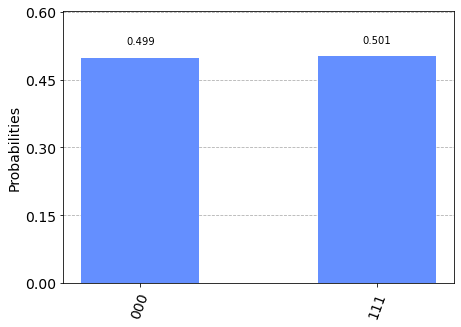

In [14]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)